## Trainable Interventions

In [1]:
__author__ = "Zhengxuan Wu"
__version__ = "11/28/2023"

### Overview

When interventions are static, you are mannually look for interesting counterfactual behaviors. What if interventions are trainable? and what if you train interventions with certain counterfactual behaviors?

We think, if you can train such interventions, you find a systematic way of affecting the causal circuits realized in the NNs. With certain types of interventions, e.g., basis respect ones (vanilla causal abstraction or DAS), you are doing causal abstraction.

In this tutorial, we show how you can train interventions with customized dataset.

### Set-up

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/frankaging/pyvene.git

[2024-01-11 01:23:38,042] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

loaded model

A program that the model can solve (Cs are input tokens):


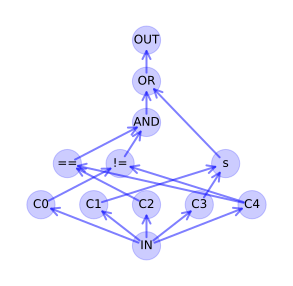

In [2]:
import os, json, torch
import numpy as np
np.object = object
import pandas as pd
from torch.utils.data import DataLoader
from datasets.utils.logging import disable_progress_bar
disable_progress_bar()

from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    LowRankRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
)
from pyvene import create_gpt2_lm

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)

from tutorial_intervention_training_utils import (
    visualize_program,
    make_supervised_counterfactual_data_module,
)
from torch.nn import CrossEntropyLoss

programs = json.load(open(os.path.join("./tutorial_data/", "seed_programs.json")))
programs_10 = json.load(
    open(os.path.join("./tutorial_data/", "selected_programs_10.json"))
)

# load fine-tuned model for this tutorial from HF
config, tokenizer, gpt2 = create_gpt2_lm("zhengxuanzenwu/gpt2-5token-solver")
tokenizer.pad_token = tokenizer.eos_token
_ = gpt2.to("cuda")
_ = gpt2.eval()

# what is this model finetuned for? this visualizes a program that this model can solve.
select_program = "07065a"
print("\nA program that the model can solve (Cs are input tokens):")
visualize_program(programs[select_program])

### Aligning the output variable with a single dimension in the rotated basis

We know the output is a boolean value, which can be represented using a single dimension (i.e., pos/neg lies on a line with a linearly separable boundary). Can we learn a 1-d DAS direction to align activations with the output variable?

We first need to sample (base, source(s)) pairs. In this case, it is easy, since the counterfactual behavior is that source output label overwrites the base one.

In [3]:
# load in some datasets we need
num_of_shots = 10
mode = "E"
counterfactual_data_module, _ = make_supervised_counterfactual_data_module(
    programs[select_program],
    800,
    num_of_shots,
    "op5",  # this is the last variable = output
    tokenizer,
    data_path="./tutorial_data/",
    program_uuid=select_program,
    mode=mode,
    n_test_sample=1000,
)

print("Model input looks like this (10-shot ICL):")
print(counterfactual_data_module["train_dataset"][0]["question"])

# dataset cleaning
columns_to_remove = [
    "question",
    "source_question",
    "answers",
    "base_answers",
    "source_answers",
]
train_dataset = (
    counterfactual_data_module["train_dataset"]
    .remove_columns(columns_to_remove)
    .with_format("torch")
)
eval_dataset = (
    counterfactual_data_module["eval_dataset"]
    .remove_columns(columns_to_remove)
    .with_format("torch")
)
test_dataset = (
    counterfactual_data_module["test_dataset"]
    .remove_columns(columns_to_remove)
    .with_format("torch")
)


def add_locations(example):
    example["source_0->base.0.pos"] = [129]  # the fixed last token location
    example["source_0->base.1.pos"] = [129]  # the fixed last token location
    example["subspaces"] = [0]  # the only subspace is a single column
    return example


train_dataset = train_dataset.map(add_locations).shuffle(seed=42)
eval_dataset = eval_dataset.map(add_locations)
test_dataset = test_dataset.map(add_locations)
train_dataloader = DataLoader(train_dataset, batch_size=64)
eval_dataloader = DataLoader(eval_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

print("\nTraining data for the intervention should contain these fields:")
print(train_dataset[0].keys())

Model input looks like this (10-shot ICL):
reportprint,itches,reenshots,Jean,reenshots=True
dated,net,dated,Kate,dated=False
Inst,Amid,Billy,While,Billy=True
mas,quickShip,mas,imei,mas=True
Excellent,embedreportprint,Ret,Theme,Excellent=True
engers,Rick,engers,Jerry,engers=True
debian,OSED,international,quickShip,international=True
Led,orous,Lead,Cash,Lead=True
mission,embedreportprint,mission,mbudsman,mission=True
ABC,store,BBC,ixty,CBC=False
ilitation,Brow,ilitation,ICLE,ilitation

Training data for the intervention should contain these fields:
dict_keys(['input_ids', 'attention_mask', 'source_input_ids', 'source_attention_mask', 'labels', 'source_0->base.0.pos', 'source_0->base.1.pos', 'subspaces'])


### A 1-d DAS direction learning config

No full rotation learning is needed here.

In [4]:
def single_d_low_rank_das_position_config(
    model_type, intervention_type, layer, intervention_types
):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,              # layer
                intervention_type,  # intervention type
                "pos",              # intervention unit
                1,                  # max number of unit
                low_rank_dimension=1,         # a single das direction
                subspace_partition=[[0, 1]],  # dummy partition
            ),
        ],
        intervention_types=intervention_types,
    )
    return config


config = single_d_low_rank_das_position_config(
    type(gpt2), "block_output", 11, LowRankRotatedSpaceIntervention
)
intervenable = IntervenableModel(config, gpt2)
intervenable.set_device("cuda")
intervenable.disable_model_gradients()

### Your own loss and metrics function

In [5]:
def inputs_collator(inputs):
    for k, v in inputs.items():
        if "->" in k:
            inputs[k] = v.tolist()
        elif "subspace" in k:
            inputs[k] = [v.tolist()]
        elif v is not None and isinstance(v, torch.Tensor):
            inputs[k] = v.to("cuda")
    return inputs


def compute_loss(logits, labels):
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    # Flatten the tokens
    loss_fct = CrossEntropyLoss()
    shift_logits = shift_logits.view(-1, 50257)
    shift_labels = shift_labels.view(-1)
    # Enable model parallelism
    shift_labels = shift_labels.to(shift_logits.device)
    loss = loss_fct(shift_logits, shift_labels)
    return loss


def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        actual_test_labels = eval_label[:, -1]
        pred_test_labels = torch.argmax(eval_pred[:, -2], dim=-1)
        correct_labels = actual_test_labels == pred_test_labels
        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
    accuracy = round(correct_count / total_count, 2)
    return {"accuracy": accuracy}["accuracy"]

### Learning

In [6]:
intervenable.train_alignment(
    train_dataloader=train_dataloader,
    compute_loss=compute_loss,
    compute_metrics=compute_metrics,
    inputs_collator=inputs_collator,
)

Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.43s/it, loss=0.24, acc=0.91]


### Evaluation

In [13]:
intervenable.eval_alignment(
    eval_dataloader=test_dataloader,
    compute_metrics=compute_metrics,
    inputs_collator=inputs_collator,
)

0.9763200000000002

The above means >97% of time, you can intervene on a single activation in the rotated basis to flip the model prediction